In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile as wave
from scipy.signal import argrelextrema as arg
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import p398dlp_read_audio_function as RA

In [2]:
def getMicros(filename):
	text = open(filename, 'r').read().split("\n")[3].split(',')

	hours = int(text[0])
	minutes = int(text[1])
	seconds = int(text[2])
	micros = int(text[3])

	microsInSec = 1e6
	microsInHour = 3600 * microsInSec
	microsInMin = 60 * microsInSec

	time = microsInHour * hours + microsInMin * minutes + microsInSec * seconds + micros

	return time

def adjustMicros(filename):
	time = open(filename, 'r').read().split("\n")
	time = [x for x in time if x != '']

	baseline = int(time[0])
	for t in range(len(time)):
		time[t] = int(time[t]) - baseline

	return time

In [3]:
def find_1st_peak(audiofile):
    #reads in the sample rate and data from the wave file as a buffer array
    #sampleRate, audio = wave.read(audiofile)
    data = RA.read_audio(audiofile, 50000000)
    #data = np.frombuffer(data, dtype=np.int16)[100:-100]

    #filter the peaks along the audio signal
    #peaks = find_peaks(data, height=np.mean(data)+6*np.std(data), distance=5000)[0]
    #print("the first peak is at", peaks[0]/32000, "seconds") # the first peak location

    #peaks_3 = find_peaks(data, height=np.mean(data)+40*np.std(data), distance=15000)[0]
    #print("the first peak_3 is at", peaks_3[0]/sampleRate, "seconds")

    #plots the audio signal
    plt.plot(data)
    #plots the peaks of signal_1
    #y = [data[i] for i in peaks]
    #plt.plot(peaks, y, 'ro',color='r')

    #plots the peaks of signal_3
    #y_3 = [data[i] for i in peaks_3] 
    #plt.plot(peaks_3,y_3,'ro',color='g')

    plt.ylabel("Amplitude")
    plt.xlabel("Samples")
    #plt.xlim([peaks[0]-10000, peaks[3]+10000])
    #plt.savefig('0.png')
    plt.show()
    return data

reading from file  sender_08.bin
ADC clock frequency (kHz)  1000.0
CPU clock frequency (kHz)  16000.0
ADC sample interval in CPU cycles  496
Arduino ADC analog pin recorded  7
Hit end of file, so exit the ADC data reading loop

All done. ADC data buffers read:  1402
ADC digitizations read:  355852
this corresponds to  0.1853395833333333  minutes of recording


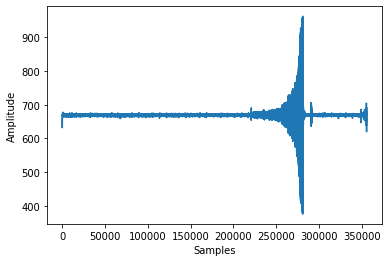

In [4]:
s_start = 210000
s = find_1st_peak('sender_08.bin')[s_start:s_start+90000]

reading from file  receiver_08.bin
ADC clock frequency (kHz)  1000.0
CPU clock frequency (kHz)  16000.0
ADC sample interval in CPU cycles  496
Arduino ADC analog pin recorded  7
Hit end of file, so exit the ADC data reading loop

All done. ADC data buffers read:  1145
ADC digitizations read:  290574
this corresponds to  0.151340625  minutes of recording


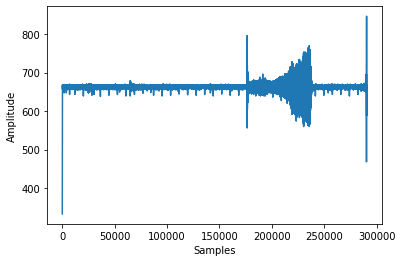

In [5]:
r_start = 170000
r = find_1st_peak('receiver_08.bin')[r_start:r_start+90000]

210000


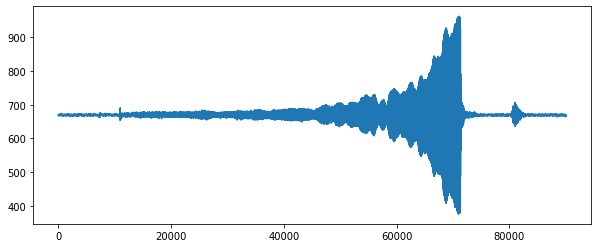

In [6]:
plt.figure(figsize=(10,4))
plt.plot(s)
print (s_start)

170000


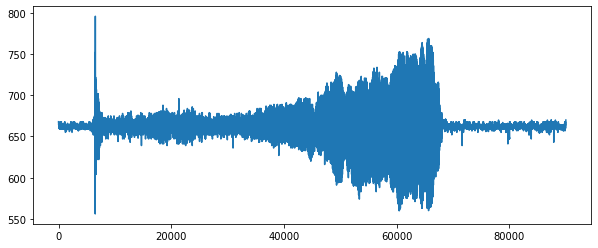

In [7]:
plt.figure(figsize=(10,4))
plt.plot(r)
print (r_start)

In [9]:
#####Plot functon with Chi-square calculation#####

def plot_shift(s, r, low_shift, high_shift, step):
    first_bin = 5000
    last_bin = 60000-5001

    s = s.astype(float) - np.mean(s)
    r = r.astype(float) - np.mean(r)
    s_normalized = s / np.sqrt(np.std(s[first_bin: last_bin]))
    r_normalized = r / np.sqrt(np.std(r[first_bin: last_bin]))

    ###############################

    # send_04, receive_04

    chisq_sum_min = 1.e12
    chisq_sum_max = -1.
    min_shift_chisq = 0
    max_shift_chisq = 0

    bin_shift_array = np.arange(low_shift, high_shift, step)
    normalized_chisq_array = np.empty(len(bin_shift_array))

    ijk = 0

    for bin_shift in range(low_shift, high_shift, step):

        chisq_sum = 0.0
        #print(bin_shift)

        for index in range(first_bin, last_bin):

            chisq_sum = chisq_sum + (s_normalized[index] - r_normalized[index + bin_shift]) ** 2 

        normalized_chisq = chisq_sum / (last_bin - first_bin + 1)

        normalized_chisq_array[ijk] = normalized_chisq
        ijk = ijk + 1

        if(normalized_chisq < chisq_sum_min):
            chisq_sum_min = normalized_chisq
            min_shift_chisq = bin_shift

        if(normalized_chisq > chisq_sum_max):
            chisq_sum_max = normalized_chisq
            max_shift_chisq = bin_shift

    print("min, max chisq: ", chisq_sum_min, chisq_sum_max)
    print("index shift for min, max: ", min_shift_chisq, max_shift_chisq)

    # plot stuff: sender, receiver 02
    plt.figure(figsize=(20,10))
    plt.plot(bin_shift_array, normalized_chisq_array)
    plt.plot(bin_shift_array, normalized_chisq_array, 'r*')

    # set labels and title
    plt.xlabel("bin shift")
    plt.ylabel("normalized chisq value")
    the_title = "sender_04, receiver_04 data"
    plt.title(the_title) 
    return normalized_chisq_array, min_shift_chisq

min, max chisq:  12.201282192261925 40.814256206275324
index shift for min, max:  -4200 5900


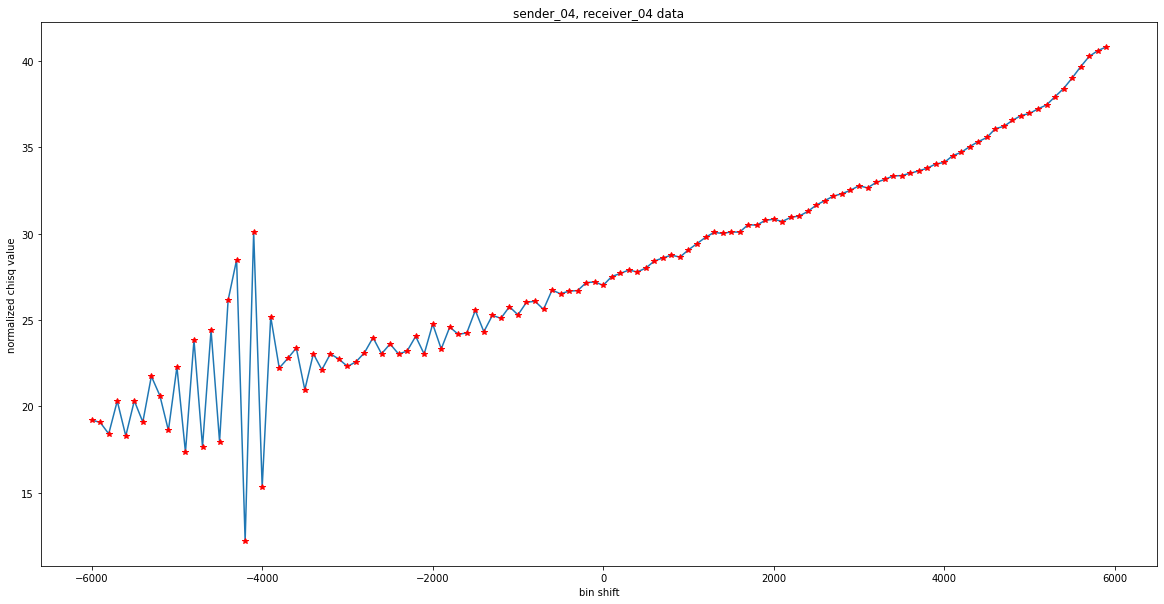

In [10]:
chi, min_shift = plot_shift(s, r, -6000, 6000, 100)

min, max chisq:  6.843729357872903 37.30818614717903
index shift for min, max:  -4280 -4310


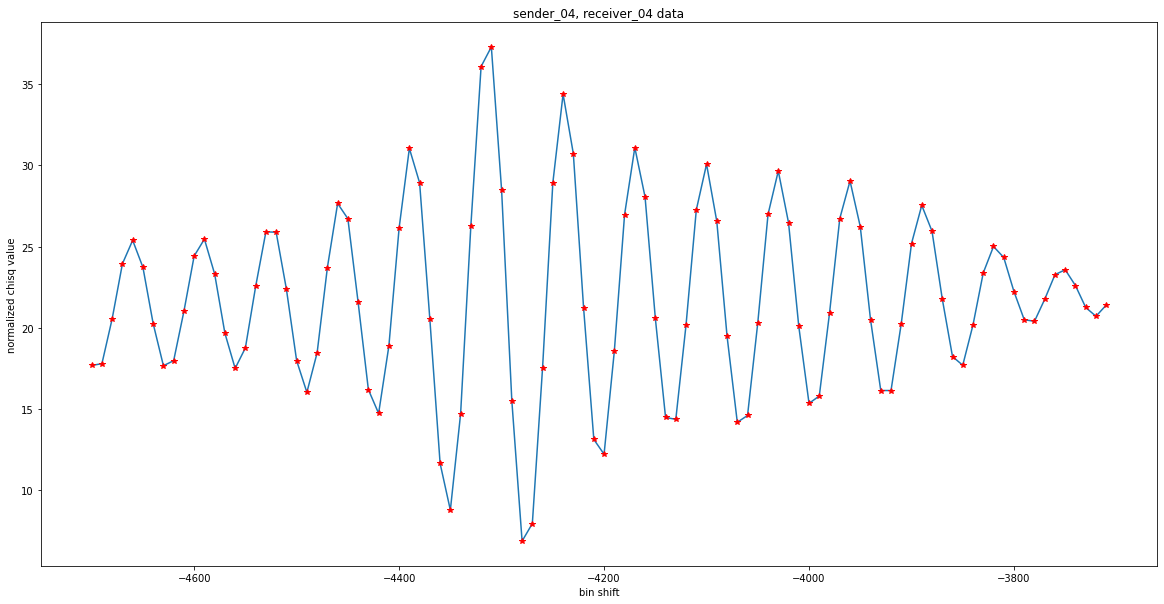

In [11]:
chi, min_shift = plot_shift(s, r, min_shift-500, min_shift+500, 10)

min, max chisq:  6.01081383795655 15.48466133638523
index shift for min, max:  -4276 -4290


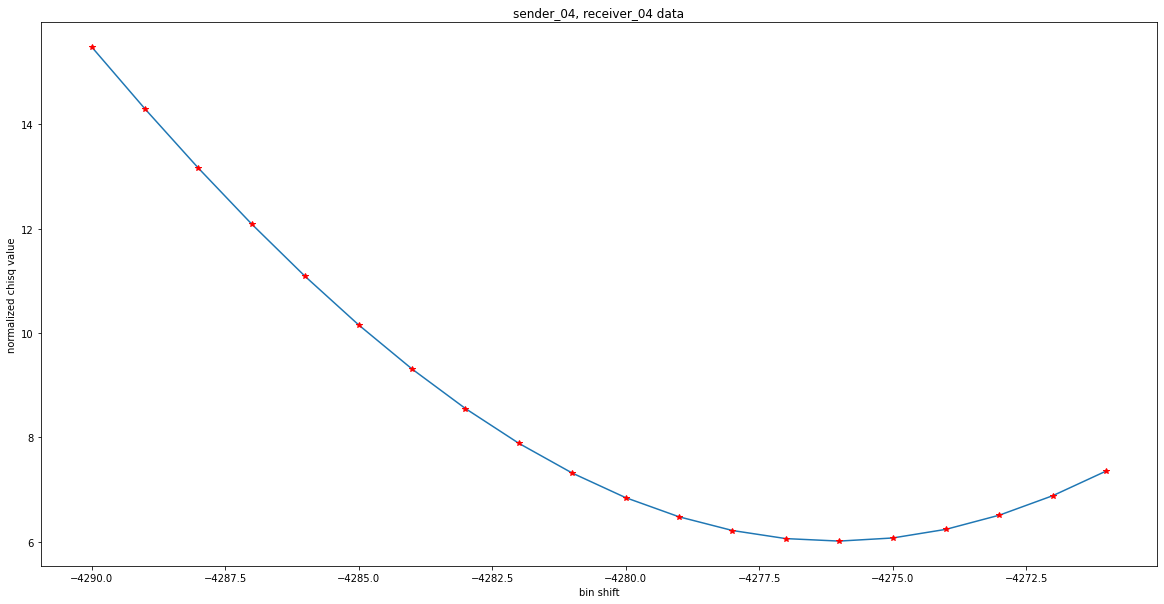

In [12]:
chi, min_shift = plot_shift(s, r, min_shift-10, min_shift+10, 1)
#print('first min bin shift:', np.argmin(chi[:20])+4560, 'chi value:', chi[:20][np.argmin(chi[:20])])
#print('second min bin shift:', np.argmin(chi[50:70])+4610, 'chi value:', chi[50:70][np.argmin(chi[50:70])])
#print('third min bin shift:', np.argmin(chi[100:110])+4660, 'chi value:', chi[100:110][np.argmin(chi[100:110])])

min, max chisq:  6.01081383795655 6.236353311812493
index shift for min, max:  -4276 -4274
-4277 : 14.294703364700698
-4276 : 13.159315250751543
-4275 : 12.085614804522681


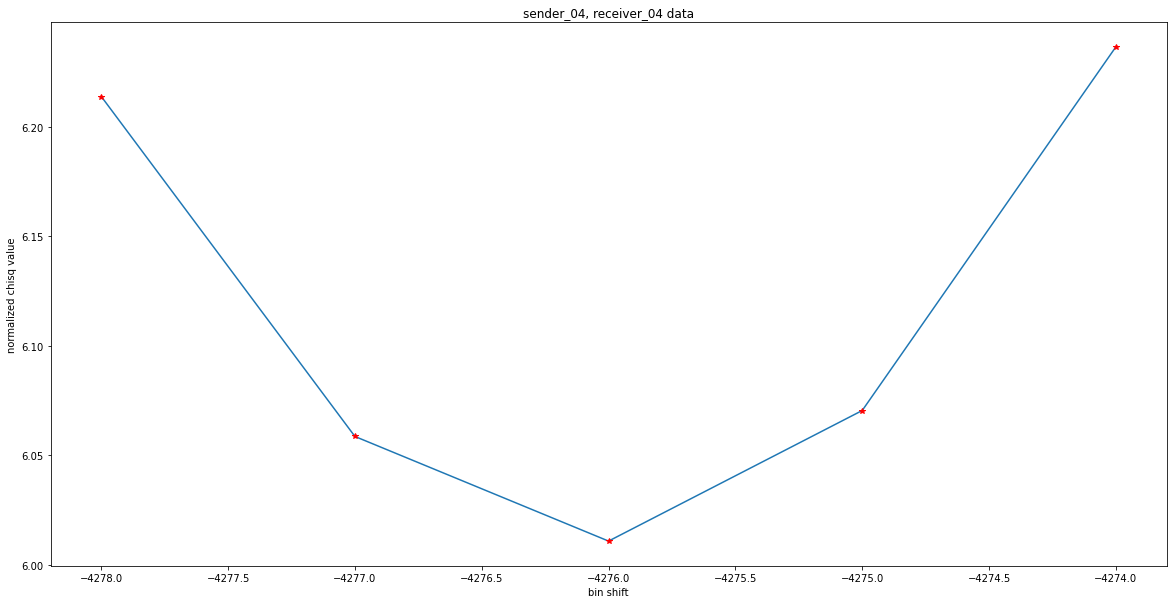

In [13]:
chi_zoom, min_shift_zoom = plot_shift(s, r, min_shift-2, min_shift+3, 1)
print(min_shift-1, ':', chi[1])
print(min_shift, ':', chi[2])
print(min_shift+1, ':', chi[3])

13.94
minimum bin shift: -4272.06 value: 6.0106463632205


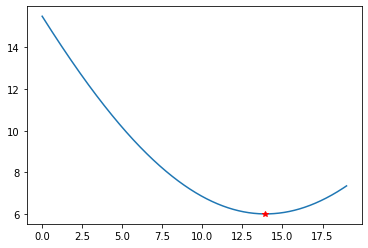

In [14]:
##Sub-time-bin precision---Method 1
x = np.arange(len(chi))
f = interp1d(x, chi, kind='cubic')
x = np.linspace(0, len(chi)-1, num=(len(chi)-1)*100, endpoint=True)
min_bin = np.argmin(f(x))/100
plt.plot(x,f(x))
plt.plot(min_bin, f(min_bin), 'r*')
print (min_bin)
print('minimum bin shift:', min_shift-10+min_bin, 'value:', f(min_bin))

In [33]:
##Sub-time-bin precision---Method 2
(-4276+(chi[4]-chi[5])/(chi[6]-chi[5])-4277)/2

-4276.099371505479

In [18]:
def microStart(meta_send, meta_receive, bin_shift, send_start, receive_start):
    sample_rate = 32000
    send_gps = getMicros(meta_send)
    receive_gps = getMicros(meta_receive)
    print (receive_gps, )
    print (receive_gps - send_gps)
    return (receive_gps - send_gps) + (receive_start - send_start + bin_shift)/sample_rate*1e6
shift = microStart('send_met_08.txt', 'receiver_met_08.txt', min_shift-10+min_bin, s_start, r_start)
print("Delay is", shift/1e6, "seconds")

13253000932.0
216.0
Delay is -1.3832858749999997 seconds
